# Analyse van SNB dataset

Eerst lezen wij de data uit en passen aan de index

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn



dataG=pd.read_csv('Grid_SNB.csv')
dataG['Time']=pd.to_datetime(dataG.Time,unit='ms')
dataG=dataG.set_index('Time',drop=True)
dataG.describe()

,Power - Grid L1,Power - Grid L2,Power - Grid L3,Total
count,34922.000000,34922.000000,34922.000000,3.504100e+04
mean,2579.092190,-2072.587069,-1010.463678,-5.022471e+02
std,99218.674105,99743.681360,100157.039502,2.985755e+05
min,-580999.232100,-587318.589300,-586255.109200,-1.754573e+06
25%,-11140.591947,-16172.023333,-14731.364720,-4.184946e+04
50%,-2146.960000,-6727.529444,-5736.947778,-1.501179e+04
75%,4640.025278,1378.113611,1801.225365,7.203437e+03
max,588681.958900,587031.844400,592102.422200,1.767781e+06


## Verbruiksprofiel analyse

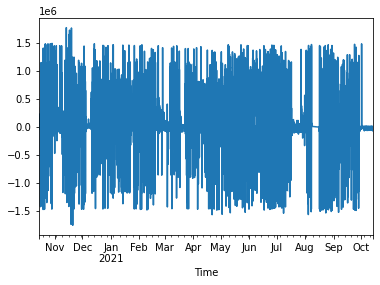

In [2]:
dataG['Total'].plot()

De dataset bevat elektrische vermogen voor een periode van 1 jaar in kwartier resolutie.

Text(0.5, 1.0, 'Dagelijkse verbruiksprofiel voor SNB')

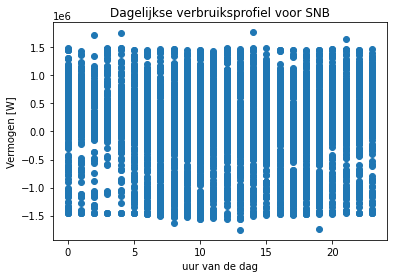

In [3]:
plt.scatter(dataG.index.hour,dataG['Total'])
plt.xlabel('uur van de dag')
plt.ylabel('Vermogen [W]')
plt.title('Dagelijkse verbruiksprofiel voor SNB')

Voor die gebruiker is het moelijk om een week/weekend trend te identificeren. De profielen zijn redelijk random.
Een alternatieve om de profiel beter te analyseren is om de gemiddelde en respectivelijke afwijking te bepalen.

(0.0, 23.0, -400000.0, 400000.0)

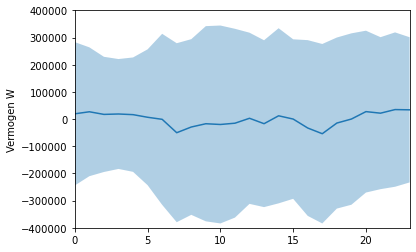

In [4]:
dataGh=pd.DataFrame()

dataGh['gemiddelde']=dataG.groupby(dataG.index.hour).mean()['Total']
dataGh['afwijking']=dataG.groupby(dataG.index.hour).std()['Total']

fig,ax=plt.subplots()
ax.plot(dataGh.index, dataGh.gemiddelde)
ax.fill_between(dataGh.index, dataGh.gemiddelde - dataGh.afwijking, dataGh.gemiddelde + dataGh.afwijking, alpha=0.35)
ax.set_ylabel('Vermogen W')
ax.axis([0,23,-400000,400000])

Het gemiddelde profiel toont zowel afname als injectie met een grote afwijking, vooral tussen 5u en 20u.

## Genormaliseerde verbruik

Het verbruiksprofiel in de dataG dataframe bevat werkelijke afname, terwijl voor de genormaliseerde verbruik is het nodig om het verbruik. Het verbruiksprofiel zal nu bepaalt worden vanuit de dataG dataframe en de zonne energie productie. Waarvoor wij moeten nog de dataset importeren als dataZ.

In [5]:
dataZ=pd.read_csv('Solar_SNB.csv')
dataZ['Time']=pd.to_datetime(dataZ.Time,unit='ms')
dataZ=dataZ.set_index('Time',drop=True)
dataZ.head()

,Power - Grid L1,Power - Grid L2,Power - Grid L3,Total
Time,,,,
2020-10-14 08:15:00,NaN,NaN,NaN,0.0
2020-10-14 08:30:00,NaN,NaN,NaN,0.0
2020-10-14 08:45:00,NaN,NaN,NaN,0.0
2020-10-14 09:00:00,NaN,NaN,NaN,0.0
2020-10-14 09:15:00,NaN,NaN,NaN,0.0


Wij zullen integreren de feature "Total" van de dataframe dataZ in de dataframe dataG. Van hieruit werken wij alleen met de dataframe dataG. Nu zullen de bruto verbruik voor de installatie.

De genormaliseerde verbruik wordt berekent zoals het totale verbruik gedurende een jaar gedeeld door de oppervlakte (1800m2). De waarde is 320151.77 kWh/m2 per jaar


,Power - Grid L1,Power - Grid L2,Power - Grid L3,Total,Productie,Verbruik,Verbruik+,Verbruik-
Time,,,,,,,,
2020-10-14 08:15:00,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0
2020-10-14 08:30:00,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0
2020-10-14 08:45:00,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0
2020-10-14 09:00:00,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0
2020-10-14 09:15:00,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0


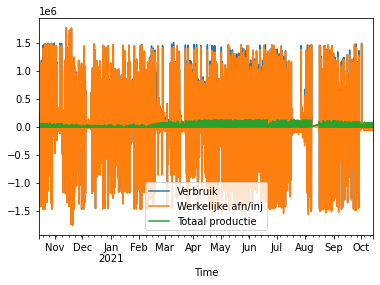

In [7]:
dataG['Productie']=dataZ['Total']
dataG['Verbruik']=dataG['Total']+dataG['Productie']
dataG['Verbruik'].plot(label='Verbruik')
dataG['Total'].plot(label='Werkelijke afn/inj')
dataZ['Total'].plot(label='Totaal productie')
plt.legend()

dataG['Verbruik+']=dataG[(dataG['Verbruik']>0)]['Verbruik']
dataG['Verbruik+']=dataG['Verbruik+'].fillna(0)

dataG['Verbruik-']=dataG[(dataG['Verbruik']<0)]['Verbruik']
dataG['Verbruik-']=dataG['Verbruik-'].fillna(0)



genor=dataG['Verbruik+'].sum()*.25/1800
print('De genormaliseerde verbruik wordt berekent zoals het totale verbruik gedurende een jaar gedeeld door de oppervlakte (1800m2). De waarde is '+str(round(genor,2))+' kWh/m2 per jaar')
dataG.head()

Volgens de Regie der gebouwen is het genormaliseerde verbruik van een gebouw in België gelijk aan 259 kWh/m2 per jaar. De installatie in deze analyse geeft een heel hogere waarde weer. Aangezien dat de installatie bevat een opslag systeem en daarbij opereert in de flexibiliteitsmarkt, wordt de vergelijking met een gewone gebouw niet van toepassing.

## Duurcurves

De curve voor zowel de afname als de productie wordt hier getoont.

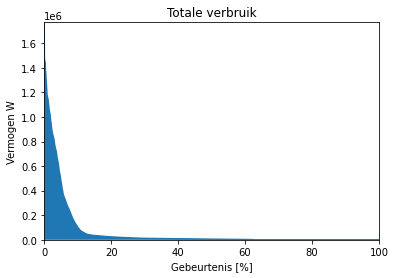

In [13]:
sort=np.sort(dataG['Verbruik+'])[::-1]
exceedence = np.arange(1.,len(sort)+1) / len(sort)

plt.plot(exceedence*100, sort)
plt.fill_between(exceedence*100, sort)
plt.xlabel("Gebeurtenis [%]")
plt.ylabel("Vermogen W")
plt.axis([0,100,sort.min(),sort.max()])
plt.title('Totale verbruik')
plt.show()

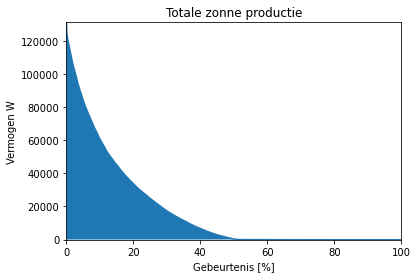

In [14]:
sort=np.sort(dataG['Productie'])[::-1]
exceedence = np.arange(1.,len(sort)+1) / len(sort)

plt.plot(exceedence*100, sort)
plt.fill_between(exceedence*100, sort)
plt.xlabel("Gebeurtenis [%]")
plt.ylabel("Vermogen W")
plt.axis([0,100,sort.min(),sort.max()])
plt.title('Totale zonne productie')
plt.show()

## Kansdichtheid

Text(0.5, 0, 'Vermogen W')

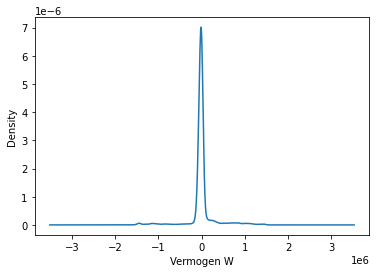

In [5]:
# Kansdichtheidsfunctie

dataG['Total'].plot.density()
plt.xlabel('Vermogen W')

## Fourier-transformatie

Text(0.5, 1.0, 'Fourier-transformatie voor afname/injectie')

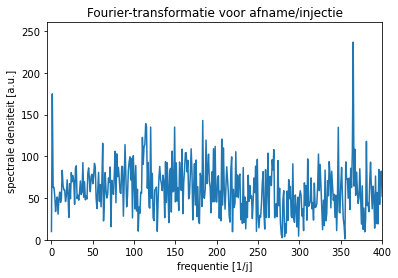

In [8]:
# Fouriertransform
dataG['Total']=dataG.Total/dataG.Total.max()
t = np.arange(35041)
sp = np.fft.fft(dataG.Total)
sp=sp[range(int(len(dataG.Total)/2))]
# freq = np.arange(int(np.size(dataG.Total)/2))/(np.size(dataG.Total)/35041)#np.fft.fftfreq(365,1/35040)
freq=np.fft.fftfreq(t.size,1/35041)[:t.size//2]
plt.plot(freq, abs(sp))
plt.xlabel('frequentie [1/j]')
plt.ylabel('spectrale densiteit [a.u.]')
plt.axis([-5,400,0,max(abs(sp))*1.1])
plt.title('Fourier-transformatie voor afname/injectie')


## Opbrengstsprofiel analyse

Text(0, 0.5, 'Vermogen W')

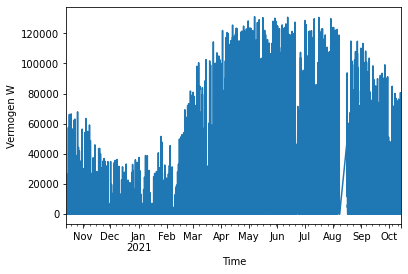

In [9]:
dataZ=pd.read_csv('Solar_SNB.csv')
dataZ['Time']=pd.to_datetime(dataZ.Time,unit='ms')
dataZ=dataZ.set_index('Time',drop=True)

dataZ['Total'].plot()
plt.ylabel('Vermogen W')

(0.0, 23.0, -6000.0, 100000.0)

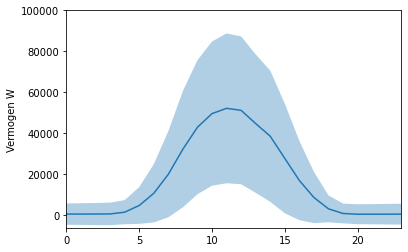

In [10]:
#Gemiddelde profiel
dataSh=pd.DataFrame()

dataSh['gemiddelde']=dataZ.groupby(dataZ.index.hour).mean()['Total']
dataSh['afwijking']=dataZ.groupby(dataZ.index.hour).std()['Total']

fig,ax=plt.subplots()
ax.plot(dataSh.index, dataSh.gemiddelde)
ax.fill_between(dataSh.index, dataSh.gemiddelde - dataSh.afwijking, dataSh.gemiddelde + dataSh.afwijking, alpha=0.35)
ax.set_ylabel('Vermogen W')
ax.axis([0,23,-6000,100000])

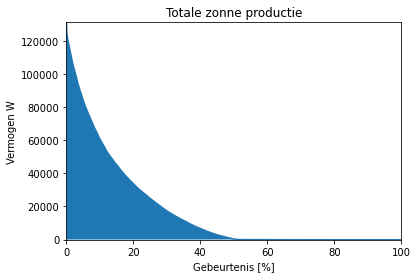

In [11]:
# Duurcurve voor productie

sort=np.sort(dataZ['Total'])[::-1]
exceedence = np.arange(1.,len(sort)+1) / len(sort)

plt.plot(exceedence*100, sort)
plt.fill_between(exceedence*100, sort)
plt.xlabel("Gebeurtenis [%]")
plt.ylabel("Vermogen W")
plt.axis([0,100,sort.min(),sort.max()])
plt.title('Totale zonne productie')
plt.show()


#  Zelf-consumptie (zc) en zelf-voorziening (zv)

Voor de zelf-consumptie berekening is het nodig om het eigenverbruik te bepalen.

,Power - Grid L1,Power - Grid L2,Power - Grid L3,Total,Productie,Verbruik,Verbruik+,Verbruik-,Eig,zv
Time,,,,,,,,,,
2020-10-14 08:15:00,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-10-14 08:30:00,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-10-14 08:45:00,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-10-14 09:00:00,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-10-14 09:15:00,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0


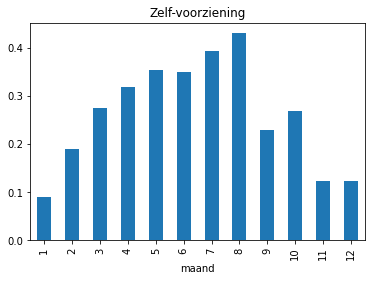

In [9]:
# Hierbij een normalisatie van de productie gegevens zodat alleen positieve warden zijn.

dataG['Productie']=dataG[(dataG['Productie']>=0)]['Productie']
dataG['Productie']=dataG['Productie'].fillna(0)
dataG['Eig']=dataG[(dataG['Productie']>dataG['Verbruik+'])]['Verbruik+']
dataG['Eig']=dataG['Eig'].fillna(dataG['Productie'])



dataG['zv']=dataG['Eig']/dataG['Verbruik+']
dataG['zv']=dataG['zv'].fillna(0)


dataG['zv'].groupby(dataG.index.month).mean().plot.bar()
plt.title('Zelf-voorziening')
plt.xlabel('maand')

dataG.head()

Text(0.5, 0, 'maand')

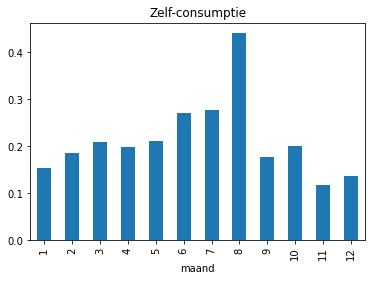

In [18]:
dataG['zc']=dataG['Eig']/dataG['Productie']
dataG['zc']=dataG['zc'].fillna(0)
dataG['zc'].groupby(dataG.index.month).mean().plot.bar()
plt.title('Zelf-consumptie')
plt.xlabel('maand')